In [1]:
# 行列、ベクター用のライブラリ
import numpy as np
# 
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from natsort import natsorted

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
import torchsummary
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.models import efficientnet_b4

In [2]:
# ネジの画像ファイルがある手前のパス
work_dir = os.getcwd()
# 訓練用画像、テスト用画像のパスをそれぞれ読み込む
train_path = os.path.join(work_dir, 'images_screw_data/train')
test_path = os.path.join(work_dir, 'images_screw_data/test')

# efficientnet_b7用
# 前処理
transform = transforms.Compose([
transforms.Resize(380),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# データセットを作成
train_val = datasets.ImageFolder(train_path, transform)
test = datasets.ImageFolder(test_path, transform)
# train, valのデータ総数
n_train_val = len(train_val)

# ハイパーパラメータの宣言
batch_size = 40
train_ratio = 0.7
val_ratio = round(1 - train_ratio, 1)

# データ分割数の設定 整数にしないとエラー出る
n_train = int(n_train_val * train_ratio)
n_val = n_train_val - n_train
n_list = [n_train, n_val]


# train, valに分割
pl.seed_everything(0)
train, val = torch.utils.data.random_split(train_val, n_list)

# DataLoader作成
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

Global seed set to 0


In [3]:
class Net(pl.LightningModule):

    def __init__(
        self, feature=efficientnet_b4(pretrained=True),
        drop_rate_1=0.45,
        # drop_rate_2=0.3,
        lr=0.00085,
        optimizer='Adagrad'
    ):
        super().__init__()
        
        self.feature = feature
        for param in self.feature.parameters():
            param.requires_grad = False
        
        self.drop_rate_1 = drop_rate_1
        # self.drop_rate_2 = drop_rate_2
        
        self.lr = lr
        self.optimizer = optimizer

        self.fc1 = nn.Linear(1000, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout2d(self.drop_rate_1)
        self.fc2 = nn.Linear(128, 2)
        # self.bn2 = nn.BatchNorm1d(2)
        # self.drop2 = nn.Dropout2d(self.drop_rate_2)
        # self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        h = self.feature(x)
        h = self.fc1(h)
        h = self.bn1(h)
        # h = F.relu(h)
        h = self.drop1(h)
        h = self.fc2(h)
        # h = self.bn2(h)
        # h = self.drop2(h)
        # h = self.fc3(h)
        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss


    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.optimizer)(self.parameters(), lr=self.lr)
        return optimizer

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# 学習の実行
pl.seed_everything(0)

# logsの確認時に変数の方が都合がよいので
save_dir, name = 'logs_b4', 'my_exp'
net = Net()
logger = CSVLogger(save_dir=save_dir, name=name)

# trainer定義
trainer = pl.Trainer(
    max_epochs=50,
    deterministic=False,
    # callbacks=[EarlyStopping(monitor='val_acc')],
    accelerator='gpu',
    devices='auto',
    logger=logger
)

# 学習
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | feature | EfficientNet | 19.3 M
1 | fc1     | Linear       | 128 K 
2 | bn1     | BatchNorm1d  | 256   
3 | drop1   | Dropout2d    | 0     
4 | fc2     | Linear       | 258   
-----------------------------------------
128 K     Trainable params
19.3 M    Non-trainable params
19.5 M    Total params
77.881    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


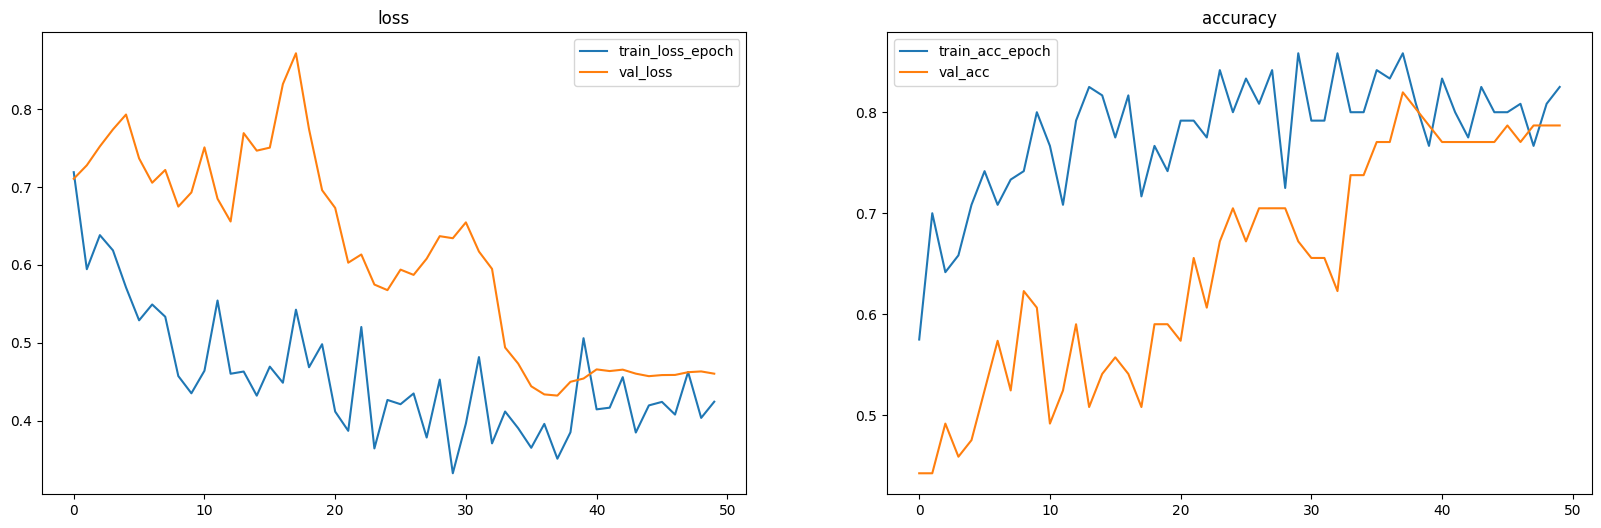

In [5]:
# logの確認
# 最新のversionのpathを取得2
paths = natsorted(glob(os.path.join(os.getcwd(), save_dir, name, 'version_*')))
log_path = os.path.join(paths[-1], 'metrics.csv')
log = pd.read_csv(log_path)

# lossとaccuracyの確認
plt.figure(figsize=(20, 6))

#loss
plt.subplot(1, 2, 1)
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();
plt.title('loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();
plt.title('accuracy')
plt.legend()

In [6]:
# テストデータで検証
results = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs_b4/my_exp/version_6/checkpoints/epoch=49-step=150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs_b4/my_exp/version_6/checkpoints/epoch=49-step=150.ckpt
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve perfor

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.75            │
│         test_loss         │    0.5838441252708435     │
└───────────────────────────┴───────────────────────────┘

In [7]:
# 学習済みモデルの保存
torch.save(net.state_dict(), 'screw_b4.pt')
# ネットワークの準備
net = Net().cpu().eval()
# 重みの読み込み
net.load_state_dict(torch.load('screw_b4.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

# accuracy, precision, recall, f1-score, 推測速度を概算する

## 一サンプル分の推測

In [20]:
pred_img, t_label =  test[0][0].unsqueeze(0), test[0][1]

In [21]:
pred_img.shape

torch.Size([1, 3, 380, 380])

In [22]:
x_label = torch.argmax(net(pred_img), dim=1).cpu().detach().numpy()

/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [23]:
x_label, t_label

(array([1]), 0)

## 複数の推測

In [7]:
x_list = []
t_list = []
tp = 0
tn = 0
fp = 0
fn = 0
# ネットワークの準備
net = Net().cpu().eval()
# 重みの読み込み
net.load_state_dict(torch.load('screw_b4.pt', map_location=torch.device('cpu')))

for num in range(len(test)):
    pred_img, t_label =  test[num][0].unsqueeze(0), test[num][1]
    x_label = torch.argmax(net(pred_img), dim=1).cpu().detach().numpy()
    # print(f'予測値：{x_label[0]} --- 目標値：{t_label}')
    if x_label[0] == 0:
        if x_label[0] == t_label:
            tp += 1
        else:
            fn += 1
    else:
        if x_label[0] == t_label:
            tn += 1
        else:
            fp += 1
        
    x_list.append(x_label[0])
    t_list.append(t_label)
    
accuracy = cnt / len(test)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * recall* precision / (recall + precision)

print(f'正解率：{cnt / len(test)}です')
print(f'Recall：{tp / (tp + fn)}です')
print(f'Precisoin：{tp / (tp + fp)}です')
print(f'f1_score：{f1_score}です')

予測値：1 --- 目標値：0
予測値：1 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：1 --- 目標値：0
予測値：0 --- 目標値：0
予測値：1 --- 目標値：0
予測値：1 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：1 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：0 --- 目標値：0
予測値：1 --- 目標値：0
予測値：1 --- 目標値：0
予測値：0 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：1 --- 目標値：1
予測値：0 --- 目標値：1
正解率：0.75です
Recall：0.8571428571428571です
Precisoin：0.6です
f1_score：0.7058823529411764です
